In [420]:
# set cell display width
from IPython.display import display, HTML
display(HTML('<style>.container { width: 900px !important; }</style>'))

In [589]:
# import ML tools
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

In [60]:
# import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')

In [61]:
# import custom palette
import my_palette as mp

In [435]:
# read in actor dataset
df = pd.read_json('capstone1_ds.json')

This dataset only contains actors from 1st to 10th billing order.

> **FULL TARGET**

In [206]:
def plot_correlations(data):
    """Return heatmap plot of correlations"""
    fig, ax = plt.subplots(figsize=(24,24))

    sns.set(font_scale=1.4)
    sns.heatmap(
        data.corr(), vmin=0, vmax=1.0, center=0, fmt='.2f', square=True, 
        linewidths=.5, annot=True, cbar_kws={"shrink": .80});

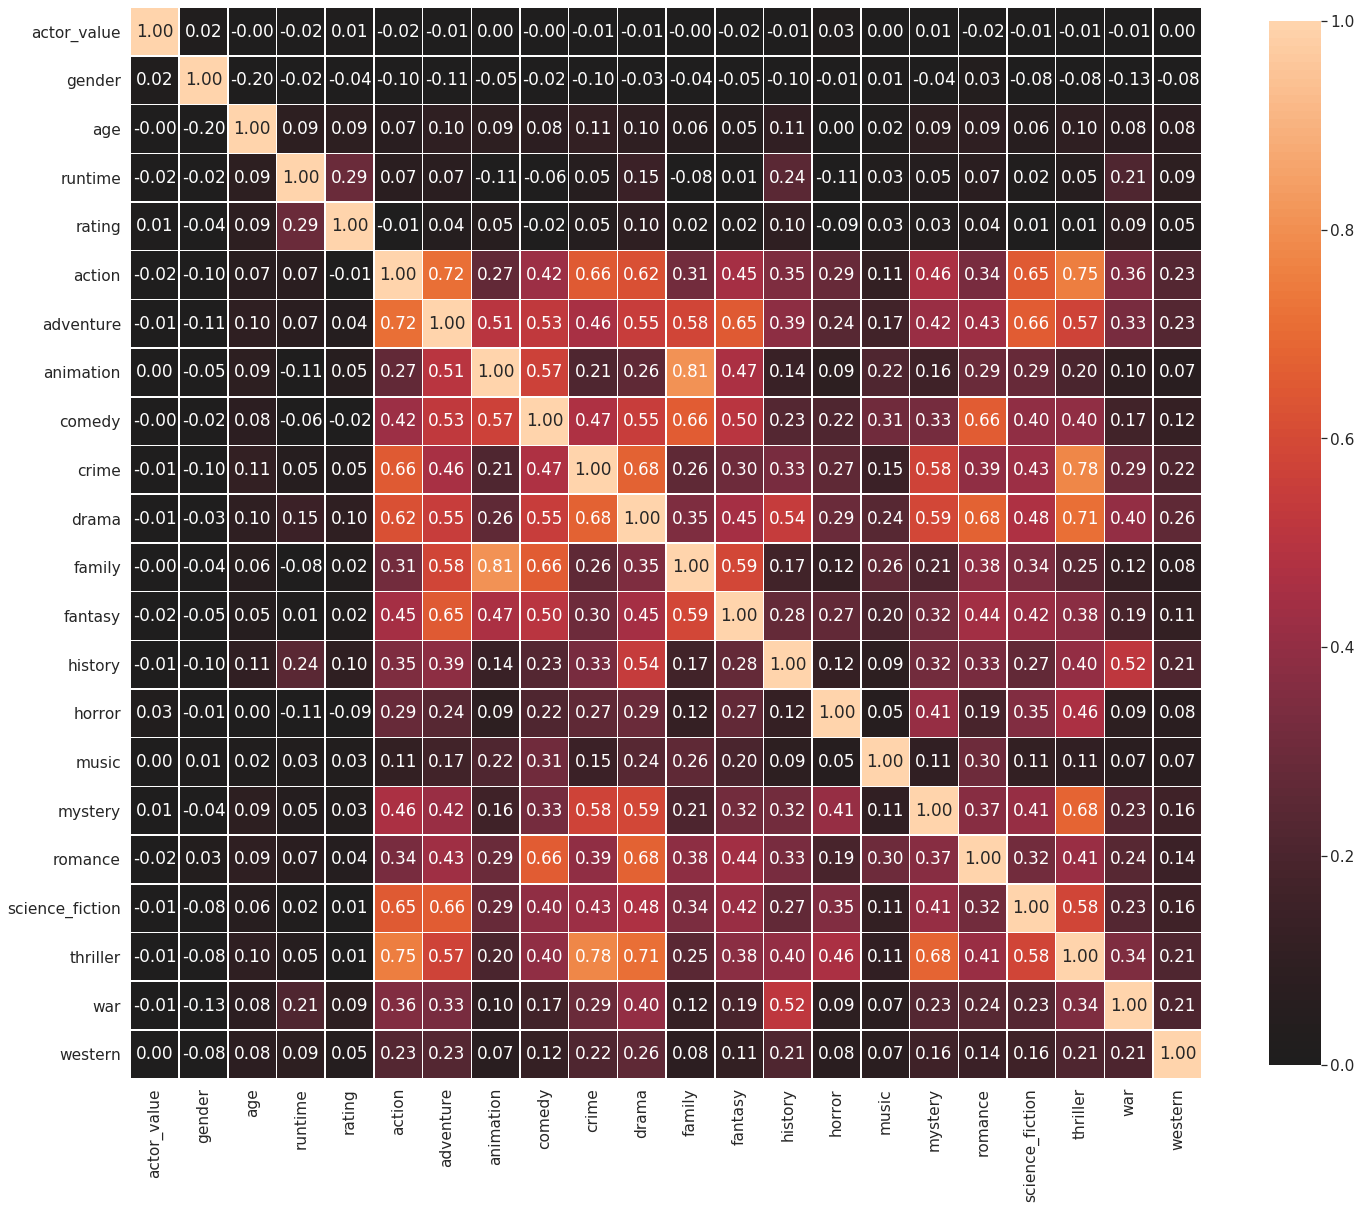

In [207]:
# plot correlations of full dataset
plot_correlations(df)

In [157]:
# separate data into features and target
features_df = df.drop('actor_value', axis=1)
target_df = df['actor_value']

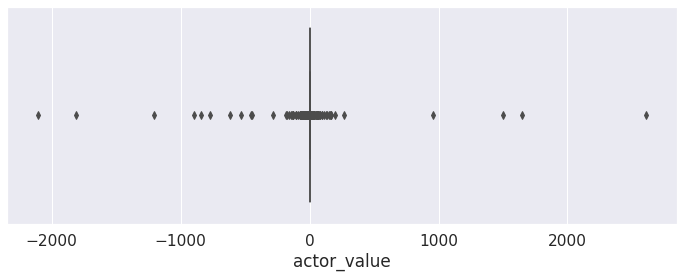

In [159]:
# plot target quartiles and outliers
sns.boxplot(target_df);

In [229]:
# get range of full target
min(target_df), max(target_df)

(-2109.7773930898, 2612.251451965)

In [158]:
# split data into train/validate and test
X, X_holdout, y, y_holdout = train_test_split(
    features_df, target_df, test_size=0.2, random_state=27)

OLS-Full Target

In [98]:
def get_ols_summary(features, target):
    """Return ordinary least squares regression results"""
    mod_ols = sm.OLS(target, features)
    results = mod_ols.fit()
    
    return print(results.summary())

In [160]:
# fit OLS regressor on full target and get summary
get_ols_summary(X, y)

                                 OLS Regression Results                                
Dep. Variable:            actor_value   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              2.314
Date:                Mon, 15 Jun 2020   Prob (F-statistic):                    0.000582
Time:                        17:29:37   Log-Likelihood:                         -62202.
No. Observations:               11996   AIC:                                  1.244e+05
Df Residuals:                   11975   BIC:                                  1.246e+05
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

RFR-Full Target

In [140]:
def get_base_model(features, target):
    """Return base random forest regressor model"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    model = RandomForestRegressor(random_state=27)
    model.fit(X_train, y_train)
    
    return model

In [308]:
def get_params(model):
    """Return hyperparameters of interest from regressor"""
    series = pd.Series(
        model.get_params(), name='full_target').drop(
        ['ccp_alpha', 'criterion', 'max_leaf_nodes', 'max_samples', 
        'min_impurity_decrease', 'min_impurity_split', 'min_weight_fraction_leaf', 
        'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
    
    return series

In [310]:
# instanciate base model and get parameters
base_model = get_base_model(X, y)
get_params(base_model)

bootstrap            True
max_depth            None
max_features         auto
min_samples_leaf        1
min_samples_split       2
n_estimators          100
Name: full_target, dtype: object

In [254]:
def get_scores(features, target, model):
    """Return root mean squared error and adjusted R2 score for regressor"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    
    rmse = mean_squared_error(y_test, model.predict(X_test), squared=False)
    r2 = r2_score(y_test, model.predict(X_test))
    n = X_train.shape[0]
    p = X_train.shape[1]
    adj_r2 = 1 - (1 - r2) * ((n - 1)  / (n - p - 1))

    return rmse, adj_r2

In [311]:
# base model scores
get_scores(X, y, base_model)

(60.45458314529033, 0.11668106148693369)

In [414]:
# standard deviation of target
np.std(y)

43.30751412363142

Random Grid Search-Full Target

In [711]:
# define parameter search grid
n_estimators = [int(x) for x in np.linspace(
    start = 200, stop = 2000, num = 10)] # number of trees
max_features = ['auto', 'sqrt'] # number of features considered at splits
max_depth = [int(x) for x in np.linspace(
    10, 110, num = 11)] # maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10] # minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4] # minimum number of samples required at each leaf node
bootstrap = [True, False] # method of selecting samples for training each tree
# create random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [133]:
# new function-old one did not return results
# have not yet run it on most targers below, only on log positive at the end
def get_best_model(features, target):
    """Return best model for randomized hyperparameter grid search"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    # instanciate model
    rfr = RandomForestRegressor()
    # instanciate grid search model
    rfr_random = RandomizedSearchCV(
        estimator=rfr, param_distributions=random_grid, n_iter=100, 
        scoring='neg_root_mean_squared_error', cv=3, verbose=1, 
        random_state=27, n_jobs=-1, return_train_score=True)
    # fit search model
    rfr_random.fit(X_train, y_train)
    # get best model
    best_model = rfr_random.best_estimator_
    # get cross-validation results
    results_df = pd.DataFrame(
        rfr_random.cv_results_).set_index(
        'rank_test_score', drop=True).sort_index()
    
    return best_model, results_df

In [163]:
# get best model for full target
best_model = get_best_model(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.3min finished


In [286]:
get_params(best_model)

bootstrap            True
max_depth            None
max_features         sqrt
min_samples_leaf        4
min_samples_split       2
n_estimators          600
Name: full_target, dtype: object

In [256]:
# get scores for best model
get_scores(X, y, best_model)

(55.93926528818777, 0.24370261967388485)

In [415]:
# standard deviation of target
np.std(y)

43.30751412363142

In [201]:
def plot_predictions(features, target, model):
    """Return plot of observed target vs. predictions"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)

    sns.scatterplot(y_test, model.predict(X_test), color=mp.colors(1))
    
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    plt.title("Ground Truth vs Predicted");

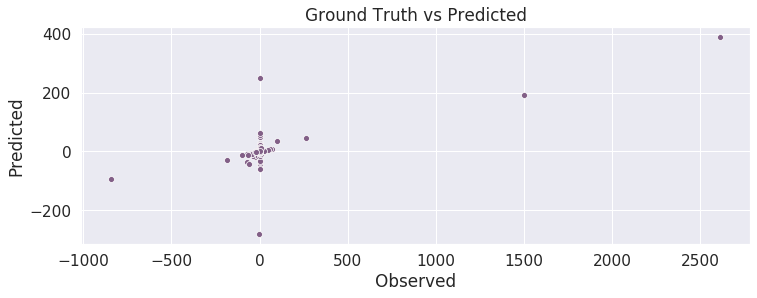

In [202]:
# plot best model observed vs. predictions using full target
plot_predictions(X, y, best_model)

In [198]:
def plot_residuals(features, target, model):
    """Return plot of residuals of observed target vs. predictions"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)

    sns.residplot(
        y_test, model.predict(X_test), lowess=True, scatter_kws={'s':10}, 
        color=mp.colors(2), line_kws={'linewidth':3})
    
    plt.xlabel('Actor Value')
    plt.ylabel('Residuals')
    
    plt.title("Ground Truth vs Predicted");

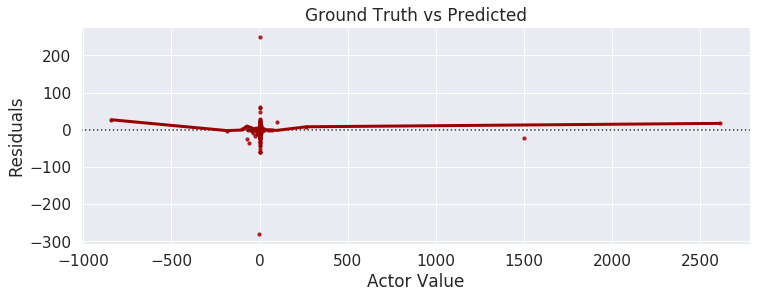

In [199]:
# plot residuals for best model using full target
plot_residuals(X, y, best_model)

In [248]:
def plot_residual_distribution(features, target, model):
    """Return plot of distribution of residuals"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    
    sns.distplot(
        (y_test - model.predict(X_test)), bins=300, rug=True, axlabel='Residual', 
        color=mp.colors(4))
    plt.axvline(
        np.median(y_test - model.predict(X_test)), ymin=0, ymax=0.88, 
        label='Median Residuals', color=mp.colors(5))
    plt.axvline(
        np.mean(y_test - model.predict(X_test)), ymin=0, ymax=0.88, 
        label='Mean Residuals', color=mp.colors(1))

    plt.ylabel('Frequency')

    plt.legend(loc=1, fontsize='xx-small', framealpha=0.3)
    plt.title('Distribution of Residuals');

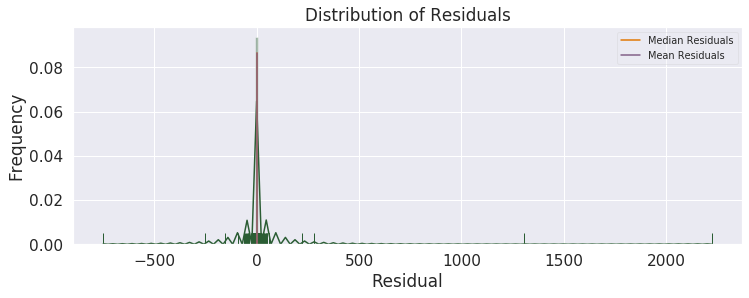

In [249]:
# plot residuals for best model using full target
plot_residual_distribution(X, y, best_model)

In [302]:
def get_feature_importances(features, model, data_spec):
    """Return DataFrame of feature importance to model"""
    df = pd.DataFrame(
        model.feature_importances_, index=features_df.columns, columns=[data_spec])
    
    return df

In [304]:
# observe important features
get_feature_importances(X, best_model, 'full_target')

,full_target
gender,0.022250
age,0.132043
runtime,0.129617
rating,0.358434
action,0.025659
adventure,0.010539
animation,0.002213
comedy,0.029384
crime,0.013775
drama,0.029081


> **NO OUTLIERS**

Look for Outliers by Interquartile Range

In [150]:
# observe interquartile range
q1 = np.percentile(df["actor_value"], 25)
q3 = np.percentile(df["actor_value"], 75)
iqr = q3 - q1
iqr

0.04742396085

In [151]:
# observe range of outliers according to IQR
upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr
lower, upper

(-0.071377825775, 0.11831801762500001)

In [316]:
# number of outlier observations according to IQR
iqr_outliers = df[(df["actor_value"] > upper) | (df["actor_value"] < lower)]
iqr_outliers.shape[0]

4356

In [318]:
# find percentage of outliers in datset according to IQR
iqr_outliers.shape[0] / df.shape[0] * 100

29.047746065617496

Look for Outliers by Z-Score

In [154]:
# create Z-score Series
z = (df["actor_value"] - np.mean(df["actor_value"])) / np.std(df["actor_value"])
# get number of outlier observations according to z-score
(np.absolute(z) > 2.5).sum()

32

In [320]:
# find percentage of outliers in datset according to Z-Score
(np.absolute(z) > 2.5).sum() / df.shape[0] * 100

0.2133902373966391

Drop Outliers > 2.5 Z-Score

In [168]:
# drop outliers target
no_df = df.drop(
    index=df.loc[np.absolute(
        np.divide(
            np.subtract(
            df["actor_value"], np.mean(df["actor_value"])
            ), np.std(df["actor_value"])
        )
    ) > 2.5].index)

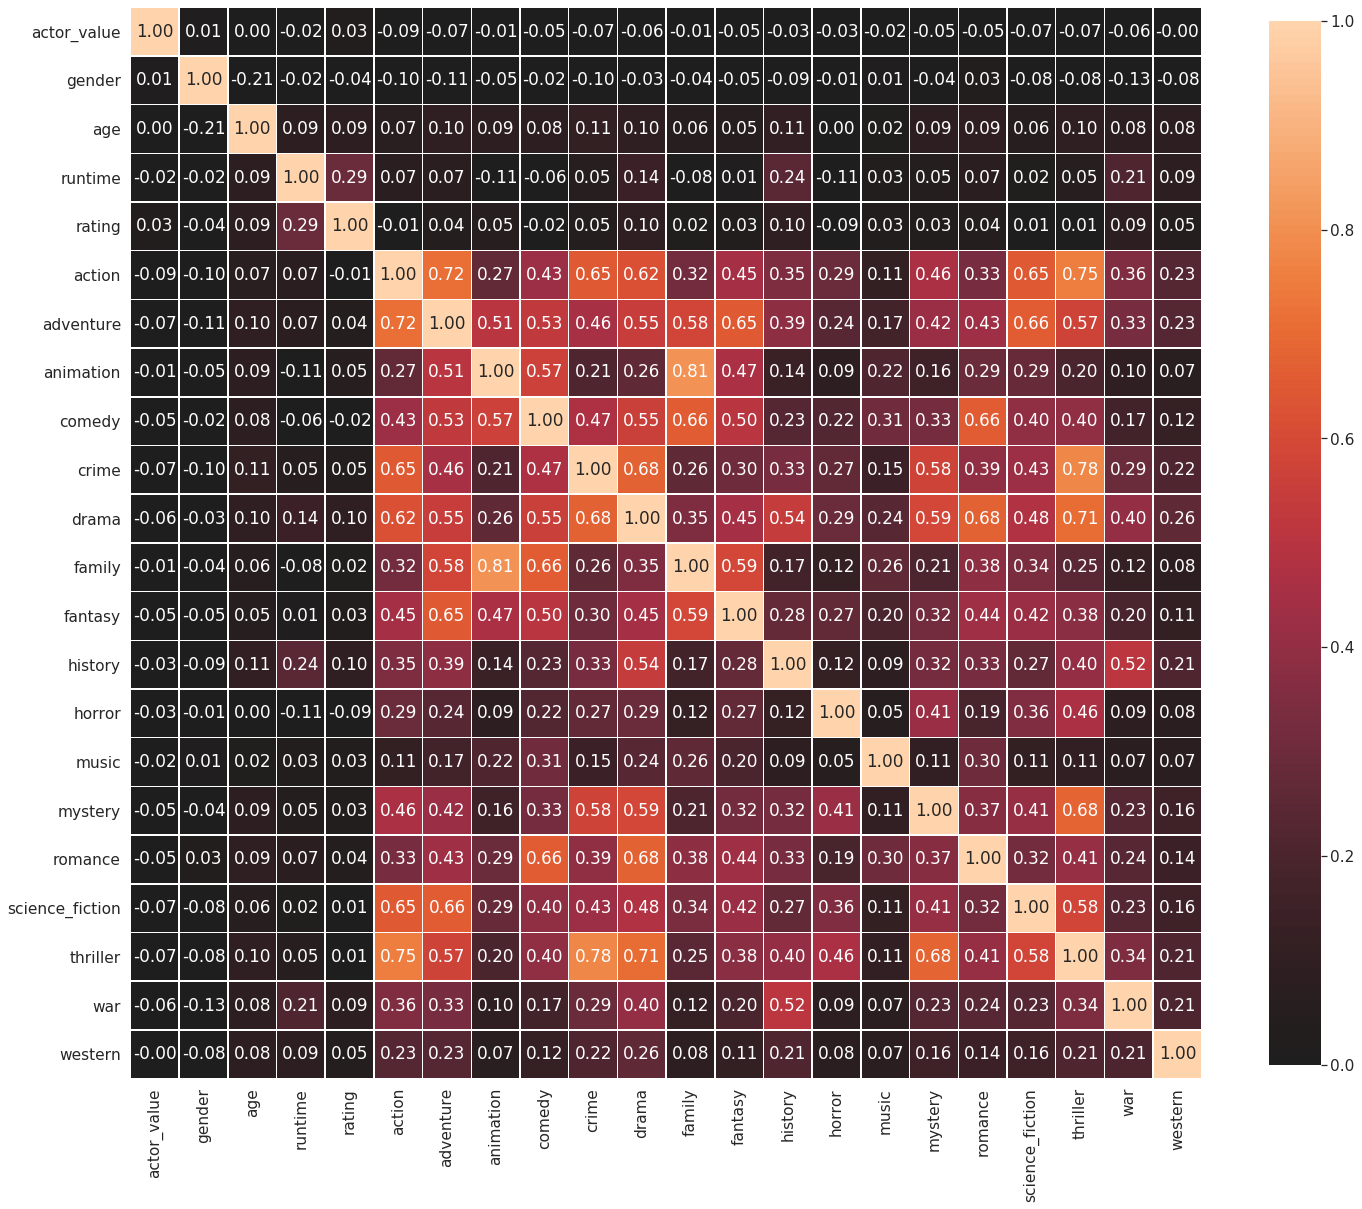

In [205]:
# plot correlations for dataset with no outlier target
plot_correlations(no_df)

In [169]:
# separate data into features and target
features_no_df = no_df.drop('actor_value', axis=1)
target_no_df = no_df['actor_value']

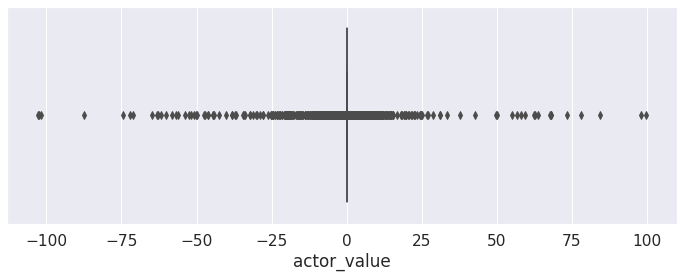

In [171]:
# plot target quartiles and outliers
sns.boxplot(target_no_df);

In [230]:
# get range of no outliers target
min(target_no_df), max(target_no_df)

(-102.8912558676, 99.7516049704)

In [170]:
# split data into train/validate and test
X_no, X_no_holdout, y_no, y_no_holdout = train_test_split(
    features_no_df, target_no_df, test_size=0.2, random_state=27)

OLS-No Outliers Target

In [172]:
# fit OLS regressor on no outliers target and get summary
get_ols_summary(X_no, y_no)

                                 OLS Regression Results                                
Dep. Variable:            actor_value   R-squared (uncentered):                   0.012
Model:                            OLS   Adj. R-squared (uncentered):              0.010
Method:                 Least Squares   F-statistic:                              6.799
Date:                Mon, 15 Jun 2020   Prob (F-statistic):                    5.63e-20
Time:                        17:40:31   Log-Likelihood:                         -34903.
No. Observations:               11971   AIC:                                  6.985e+04
Df Residuals:                   11950   BIC:                                  7.000e+04
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

RFR-No Outliers Target

In [312]:
# instanciate base model for no outliers target and get parameters
base_model_no = get_base_model(X_no, y_no)
get_params(base_model_no)

bootstrap            True
max_depth            None
max_features         auto
min_samples_leaf        1
min_samples_split       2
n_estimators          100
Name: full_target, dtype: object

In [315]:
# base model scores for no outliers target
get_scores(X_no, y_no, base_model_no)

(5.198880651099021, -0.04149720198291629)

In [416]:
# standard deviation of target
np.std(y_no)

4.493304970420639

Grid Search-No Outliers Target

In [175]:
# get best model for no outliers target
best_model_no = get_best_model(X_no, y_no)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.8min finished


In [287]:
get_params(best_model_no)

bootstrap            True
max_depth             100
max_features         sqrt
min_samples_leaf        4
min_samples_split      10
n_estimators         1000
Name: full_target, dtype: object

In [258]:
# get scores for best model with no outliers target
get_scores(X_no, y_no, best_model_no)

(4.437281412553393, 0.24129602842693154)

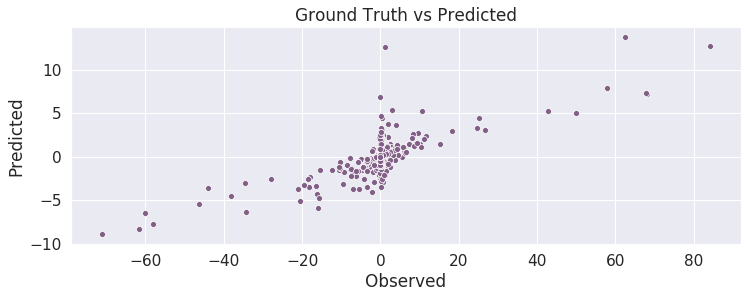

In [203]:
# plot best model observed vs. predictions using no outliers target
plot_predictions(X_no, y_no, best_model_no)

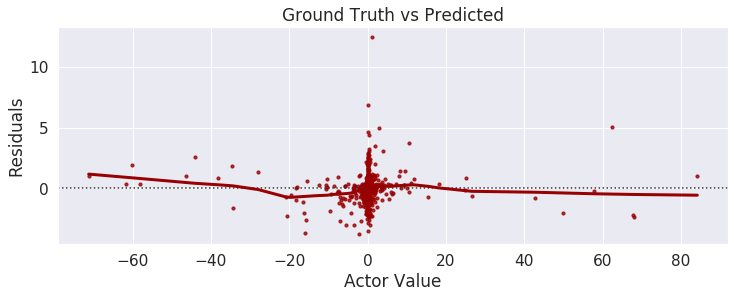

In [200]:
# plot residuals for best model using no outliers target
plot_residuals(X_no, y_no, best_model_no)

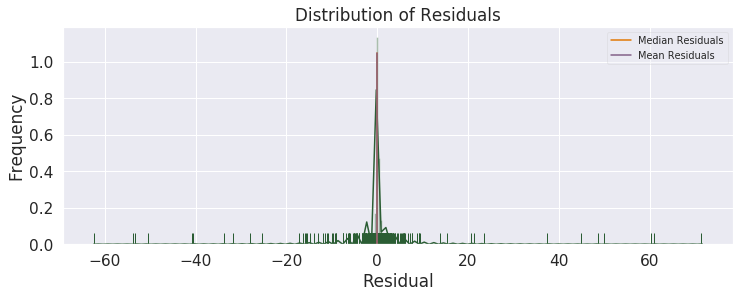

In [250]:
# plot residuals for best model using no outliers target
plot_residual_distribution(X_no, y_no, best_model_no)

In [305]:
# observe important features
get_feature_importances(X_no, best_model_no, 'no_outlier_target')

,no_outlier_target
gender,0.032477
age,0.172022
runtime,0.117047
rating,0.196112
action,0.046179
adventure,0.035956
animation,0.013522
comedy,0.048900
crime,0.036960
drama,0.054944


> **POSITIVE VALUES**

In [436]:
# keep only posivive target
pos_df = df[df['actor_value'] > 0]

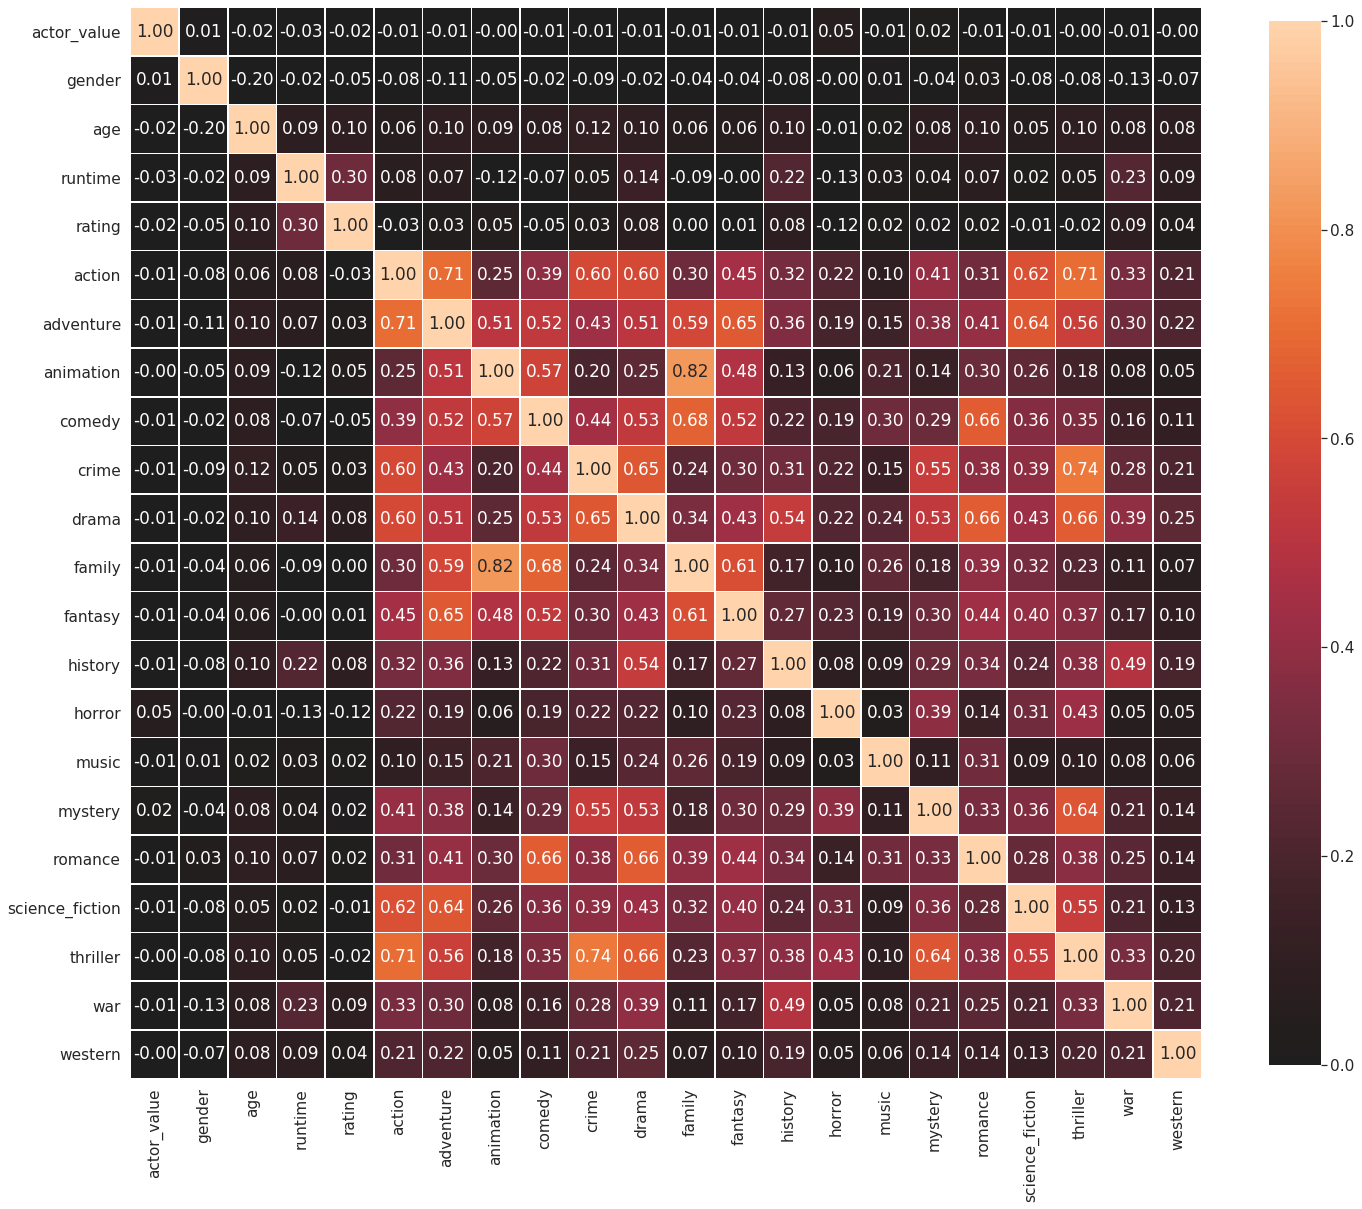

In [442]:
# plot correlations for dataset with positive value target
plot_correlations(pos_df)

In [443]:
# separate data into features and target
features_pos_df = pos_df.drop('actor_value', axis=1)
target_pos_df = pos_df['actor_value']

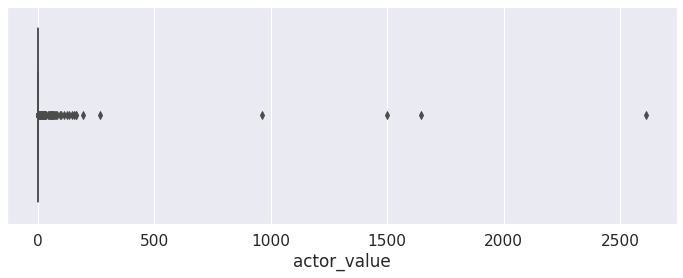

In [211]:
# plot target quartiles and outliers
sns.boxplot(target_pos_df);

In [231]:
# get range of positive target
min(target_pos_df), max(target_pos_df)

(2.49e-08, 2612.251451965)

In [212]:
# split data into train/validate and test
X_pos, X_pos_holdout, y_pos, y_pos_holdout = train_test_split(
    features_pos_df, target_pos_df, test_size=0.2, random_state=27)

OLS-Positive Target

In [213]:
# fit OLS regressor on positive target and get summary
get_ols_summary(X_pos, y_pos)

                                 OLS Regression Results                                
Dep. Variable:            actor_value   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.005
Method:                 Least Squares   F-statistic:                              2.949
Date:                Tue, 16 Jun 2020   Prob (F-statistic):                    6.86e-06
Time:                        00:48:12   Log-Likelihood:                         -42618.
No. Observations:                8375   AIC:                                  8.528e+04
Df Residuals:                    8354   BIC:                                  8.543e+04
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

RFR-Positive Target

In [313]:
# instanciate base model for positive target and get parameters
base_model_pos = get_base_model(X_pos, y_pos)
get_params(base_model_pos)

bootstrap            True
max_depth            None
max_features         auto
min_samples_leaf        1
min_samples_split       2
n_estimators          100
Name: full_target, dtype: object

In [314]:
# base model scores for positive target
get_scores(X_pos, y_pos, base_model_pos)

(40.11922880511344, -42.38304664642231)

In [417]:
# standard deviation of target
np.std(y_pos)

39.363856946158656

Grid Search-Positive Target

In [216]:
# get best model for positive target
best_model_pos = get_best_model(X_pos, y_pos)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.7min finished


In [288]:
get_params(best_model_pos)

bootstrap            True
max_depth              20
max_features         sqrt
min_samples_leaf        1
min_samples_split       2
n_estimators         1200
Name: full_target, dtype: object

In [419]:
# get scores for best model with positive target
get_scores(X_pos, y_pos, best_model_pos)

(8.335666442030275, -0.8728178966361817)

In [418]:
# standard deviation of target
np.std(y_pos)

39.363856946158656

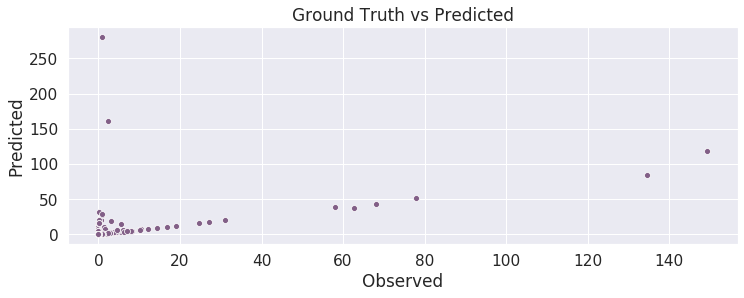

In [219]:
# plot best model observed vs. predictions using positive target
plot_predictions(X_pos, y_pos, best_model_pos)

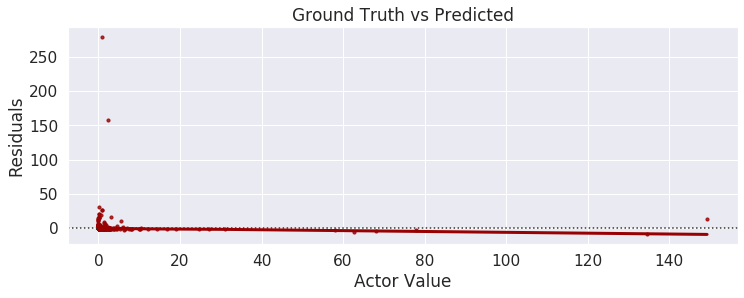

In [220]:
# plot residuals for best model using positive target
plot_residuals(X_pos, y_pos, best_model_pos)

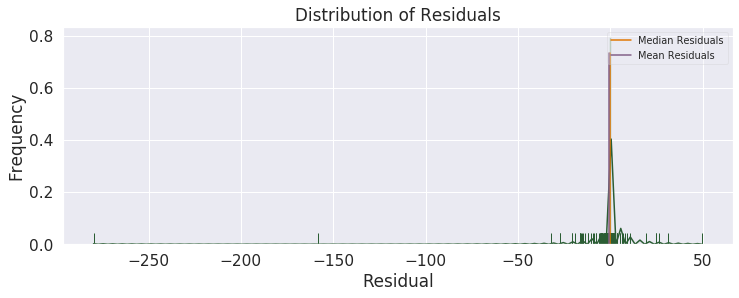

In [251]:
# plot residuals for best model using positive target
plot_residual_distribution(X_pos, y_pos, best_model_pos)

In [307]:
# observe important features
get_feature_importances(X_pos, best_model_pos, 'positive_target')

,positive_target
gender,0.049436
age,0.177947
runtime,0.129221
rating,0.229469
action,0.007949
adventure,0.005184
animation,0.001538
comedy,0.017962
crime,0.012010
drama,0.038142


> **LOG POSITIVE VALUES**

In [440]:
# take natural log of posivite target
log_pos_df = pos_df.copy()
log_pos_df['actor_value'] = np.log(log_pos_df['actor_value'])

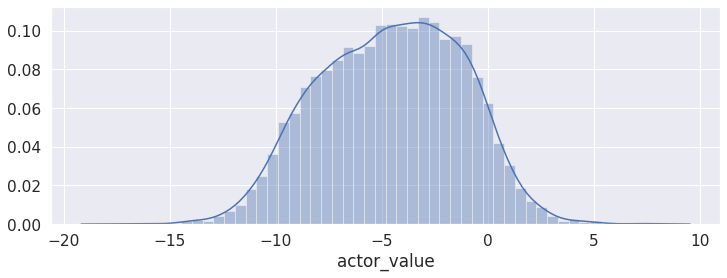

In [445]:
sns.distplot(log_pos_df['actor_value']);

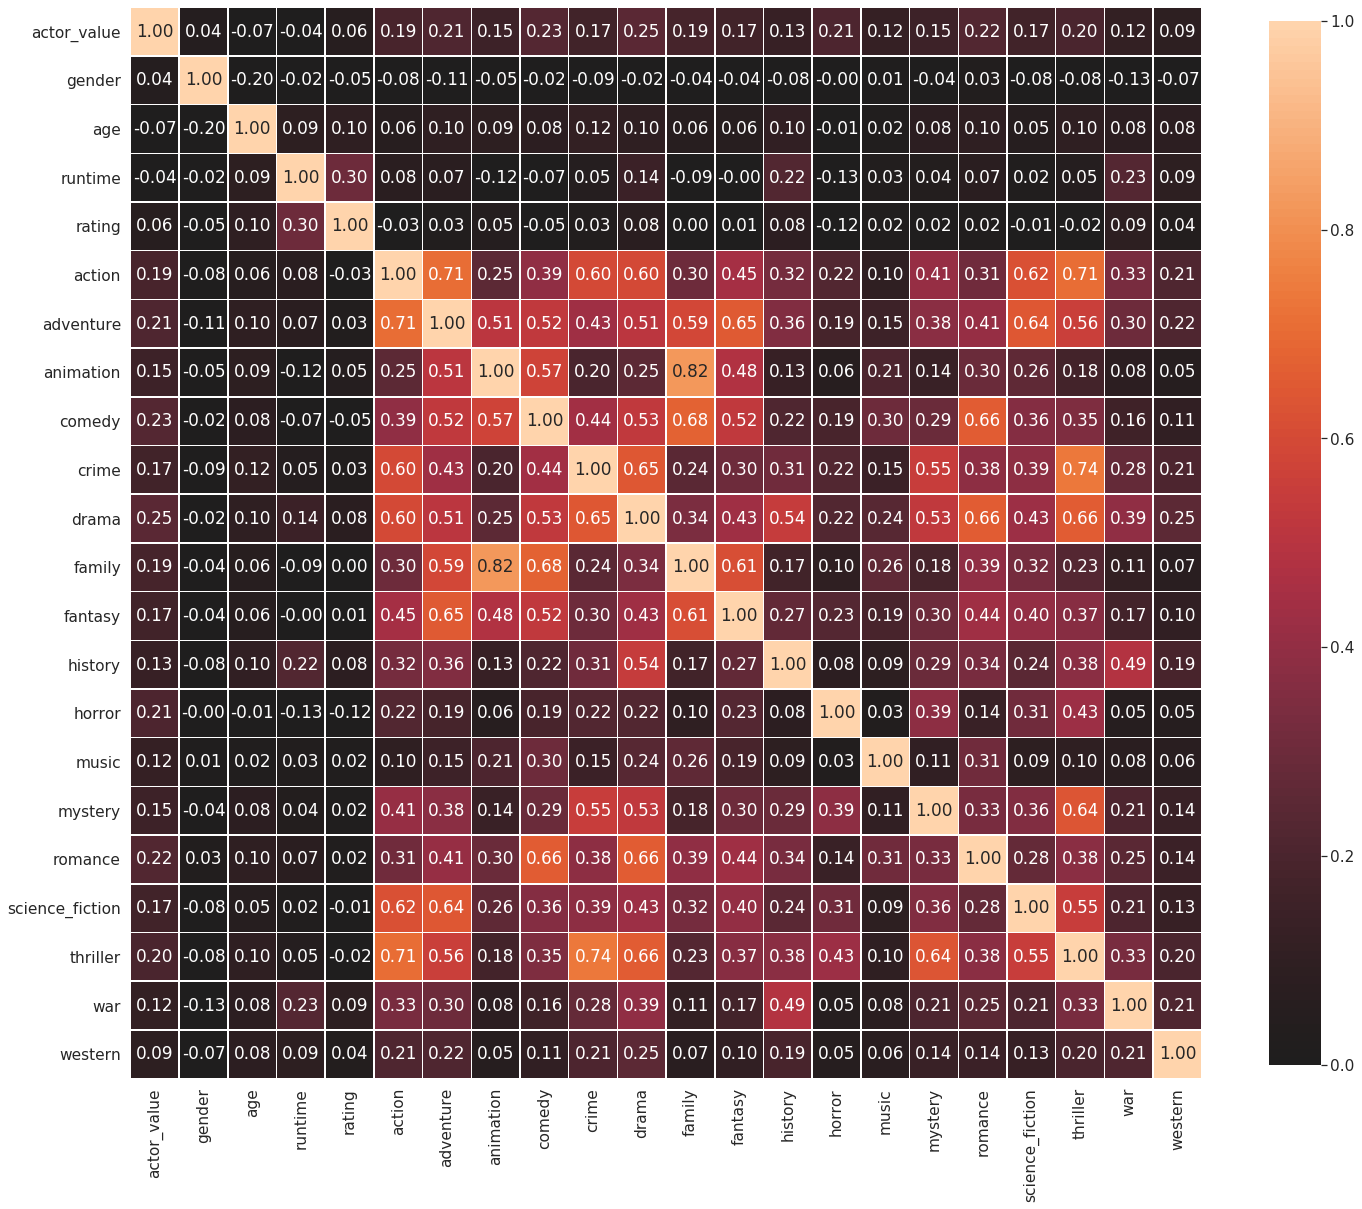

In [441]:
# plot correlations for dataset with natural log of positive value target
plot_correlations(log_pos_df)

In [444]:
# separate data into features and target
features_log_pos_df = log_pos_df.drop('actor_value', axis=1)
target_log_pos_df = log_pos_df['actor_value']

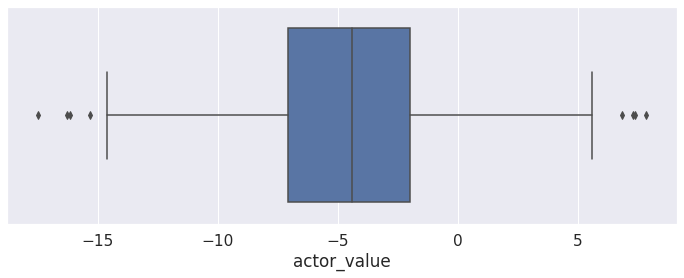

In [446]:
# plot target quartiles and outliers
sns.boxplot(target_log_pos_df);

In [447]:
# get range of natural log of positive target
min(target_log_pos_df), max(target_log_pos_df)

(-17.50839803347575, 7.867967753743332)

In [448]:
# split data into train/validate and test
X_log_pos, X_log_pos_holdout, y_log_pos, y_log_pos_holdout = train_test_split(
    features_log_pos_df, target_log_pos_df, test_size=0.2, random_state=27)

OLS-Natural Log Positive Target

In [449]:
# fit OLS regressor on natural log of positive target and get summary
get_ols_summary(X_log_pos, y_log_pos)

                                 OLS Regression Results                                
Dep. Variable:            actor_value   R-squared (uncentered):                   0.692
Model:                            OLS   Adj. R-squared (uncentered):              0.691
Method:                 Least Squares   F-statistic:                              892.2
Date:                Thu, 18 Jun 2020   Prob (F-statistic):                        0.00
Time:                        12:37:39   Log-Likelihood:                         -21420.
No. Observations:                8375   AIC:                                  4.288e+04
Df Residuals:                    8354   BIC:                                  4.303e+04
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

RFR-Natural Log Positive Target

In [450]:
# instanciate base model for  natural log of positive target and get parameters
base_model_log_pos = get_base_model(X_log_pos, y_log_pos)
get_params(base_model_log_pos)

bootstrap            True
max_depth            None
max_features         auto
min_samples_leaf        1
min_samples_split       2
n_estimators          100
Name: full_target, dtype: object

In [451]:
# base model scores for natural log of positive target
get_scores(X_log_pos, y_log_pos, base_model_log_pos)

(2.9628198181046956, 0.1865592257571861)

In [452]:
# standard deviation of target
np.std(y_log_pos)

3.312283301007384

Grid Search-Natural Log of Positive Target

In [453]:
# get best model for natural log of positive target
best_model_log_pos = get_best_model(X_log_pos, y_log_pos)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.0min finished


In [454]:
get_params(best_model_log_pos)

bootstrap            True
max_depth            None
max_features         sqrt
min_samples_leaf        1
min_samples_split      10
n_estimators          800
Name: full_target, dtype: object

In [455]:
# get scores for best model with natural log of positive target
get_scores(X_log_pos, y_log_pos, best_model_log_pos)

(2.089043346001416, 0.5956007339840241)

In [457]:
# standard deviation of target
np.std(y_log_pos)

3.312283301007384

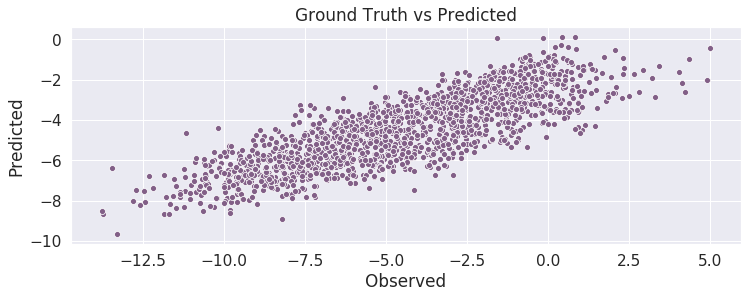

In [458]:
# plot best model observed vs. predictions using natural log of positive target
plot_predictions(X_log_pos, y_log_pos, best_model_log_pos)

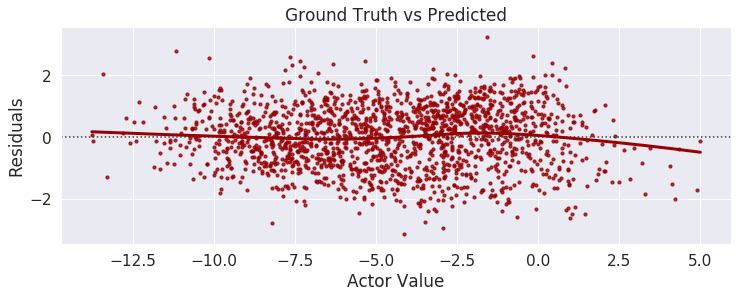

In [459]:
# plot residuals for best model using natural log of positive target
plot_residuals(X_log_pos, y_log_pos, best_model_log_pos)

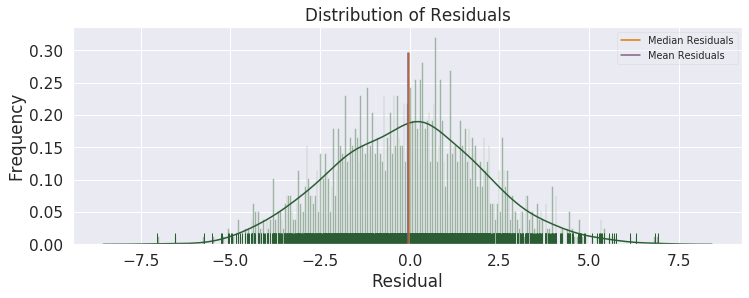

In [460]:
# plot residuals for best model using natural log of positive target
plot_residual_distribution(X_log_pos, y_log_pos, best_model_log_pos)

In [461]:
# observe important features
get_feature_importances(X_log_pos, best_model_log_pos, 'log positive_target')

,log positive_target
gender,0.021588
age,0.152361
runtime,0.110458
rating,0.164537
action,0.037641
adventure,0.041662
animation,0.013129
comedy,0.066687
crime,0.024479
drama,0.090265


> **NEW SEARCH GRID**

In [713]:
# create new parameter search grid
random_grid = {
    'n_estimators': [int(x) for x in np.linspace(600, 2400, num=10)],
    'max_depth': [int(x) for x in np.linspace(10, 100, num=10)],
    'min_samples_split': [int(x) for x in np.linspace(1, 10, num=10)],
    'min_samples_leaf': [int(x) for x in np.linspace(1, 10, num=10)],
    'max_features': [int(x) for x in np.linspace(1, 10, num=10)]}
random_grid

{'n_estimators': [600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

In [714]:
best_model_log_pos, log_pos_results_df = get_best_model(X_log_pos, y_log_pos)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.2min finished


In [600]:
# first random grid
# get scores for best model with natural log of positive target
get_scores(X_log_pos, y_log_pos, best_model_log_pos)

(2.8940883413444407, 0.22386186371864825)

In [715]:
# second random grid
# get scores for best model with natural log of positive target
get_scores(X_log_pos, y_log_pos, best_model_log_pos)

(2.8953840376370725, 0.22316674712114326)

In [653]:
# first random grid
log_pos_results_df.head(10).iloc[:, -17:-11]

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap
rank_test_score,,,,,,
1,800,10,2,sqrt,80,True
2,1400,2,2,sqrt,20,True
3,1200,2,4,sqrt,20,True
4,2000,5,4,sqrt,20,True
5,1200,5,4,sqrt,20,True
6,1200,10,4,sqrt,30,True
7,1800,2,4,sqrt,20,True
8,1600,10,4,sqrt,80,True
9,600,2,4,sqrt,None,True


In [716]:
# second random grid
log_pos_results_df.head(10).iloc[:, -17:-11]

,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth
rank_test_score,,,,,,
1,0.032132,600,8,2,3,20
2,0.200592,2400,7,4,5,20
3,0.023695,1000,3,4,4,30
4,0.044592,1000,10,3,3,20
5,0.007591,1800,5,4,5,40
6,0.186705,2200,9,1,4,70
7,0.262193,2400,7,3,5,60
8,0.010404,1600,2,5,5,70
9,0.095412,1600,6,4,6,20


In [649]:
# first random grid
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [717]:
# second random grid
random_grid

{'n_estimators': [600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

In [648]:
# first random grid
# best parameters
log_pos_results_df['params'][1]

{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': True}

In [718]:
# second random grid
# best parameters
log_pos_results_df['params'][1]

{'n_estimators': 600,
 'min_samples_split': 8,
 'min_samples_leaf': 2,
 'max_features': 3,
 'max_depth': 20}

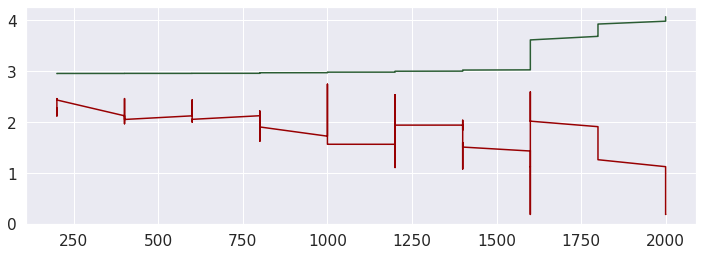

In [639]:
# first random grid
plt.plot(log_pos_results_df['param_n_estimators'].sort_values(), 
         log_pos_results_df['mean_train_score'] * -1, color=mp.colors(2))
plt.plot(log_pos_results_df['param_n_estimators'].sort_values(), 
         log_pos_results_df['mean_test_score'] * -1, color=mp.colors(4));

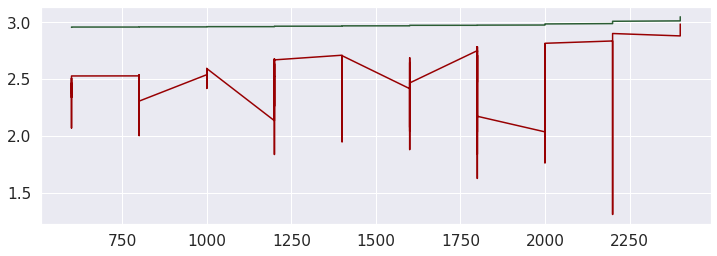

In [720]:
# second random grid
plt.plot(log_pos_results_df['param_n_estimators'].sort_values(), 
         log_pos_results_df['mean_train_score'] * -1, color=mp.colors(2))
plt.plot(log_pos_results_df['param_n_estimators'].sort_values(), 
         log_pos_results_df['mean_test_score'] * -1, color=mp.colors(4));

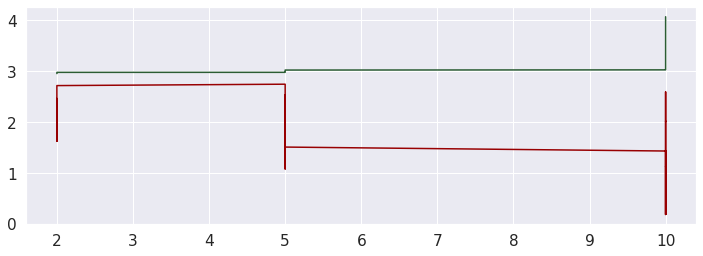

In [643]:
# first random grid
plt.plot(log_pos_results_df['param_min_samples_split'].sort_values(), 
         log_pos_results_df['mean_train_score'] * -1, color=mp.colors(2))
plt.plot(log_pos_results_df['param_min_samples_split'].sort_values(), 
         log_pos_results_df['mean_test_score'] * -1, color=mp.colors(4));

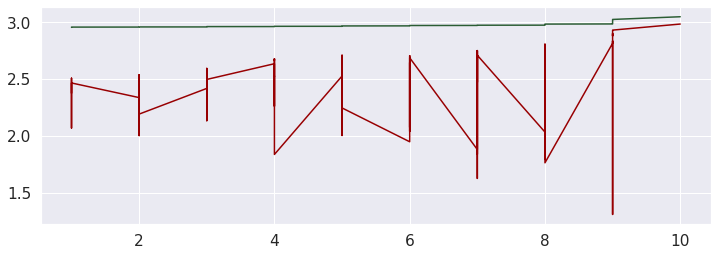

In [721]:
# second random grid
plt.plot(log_pos_results_df['param_min_samples_split'].sort_values(), 
         log_pos_results_df['mean_train_score'] * -1, color=mp.colors(2))
plt.plot(log_pos_results_df['param_min_samples_split'].sort_values(), 
         log_pos_results_df['mean_test_score'] * -1, color=mp.colors(4));

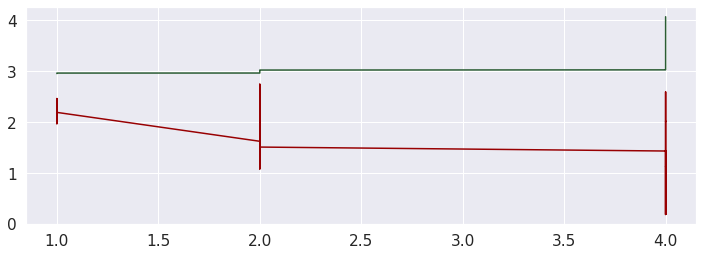

In [644]:
# first random grid
plt.plot(log_pos_results_df['param_min_samples_leaf'].sort_values(), 
         log_pos_results_df['mean_train_score'] * -1, color=mp.colors(2))
plt.plot(log_pos_results_df['param_min_samples_leaf'].sort_values(), 
         log_pos_results_df['mean_test_score'] * -1, color=mp.colors(4));

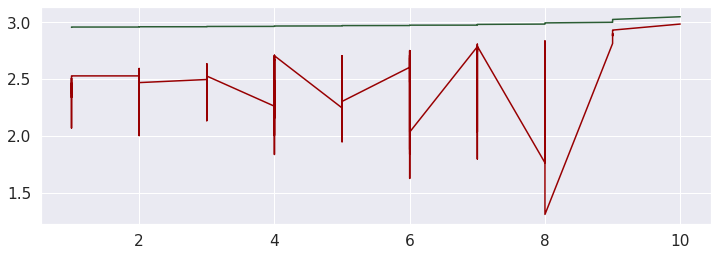

In [723]:
# second random grid
plt.plot(log_pos_results_df['param_min_samples_leaf'].sort_values(), 
         log_pos_results_df['mean_train_score'] * -1, color=mp.colors(2))
plt.plot(log_pos_results_df['param_min_samples_leaf'].sort_values(), 
         log_pos_results_df['mean_test_score'] * -1, color=mp.colors(4));

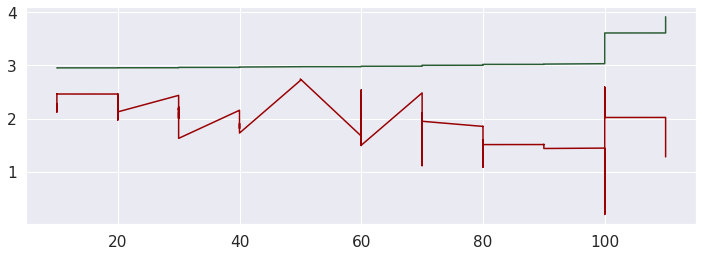

In [645]:
# first random grid
plt.plot(log_pos_results_df['param_max_depth'].sort_values(), 
         log_pos_results_df['mean_train_score'] * -1, color=mp.colors(2))
plt.plot(log_pos_results_df['param_max_depth'].sort_values(), 
         log_pos_results_df['mean_test_score'] * -1, color=mp.colors(4));

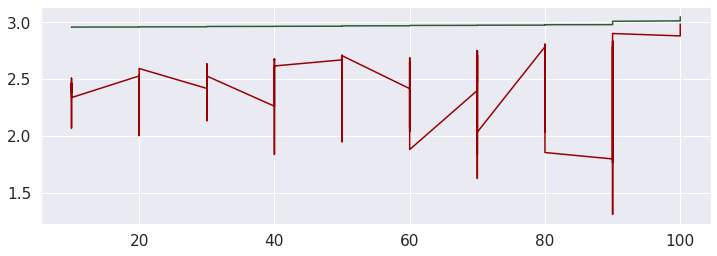

In [724]:
# second random grid
plt.plot(log_pos_results_df['param_max_depth'].sort_values(), 
         log_pos_results_df['mean_train_score'] * -1, color=mp.colors(2))
plt.plot(log_pos_results_df['param_max_depth'].sort_values(), 
         log_pos_results_df['mean_test_score'] * -1, color=mp.colors(4));

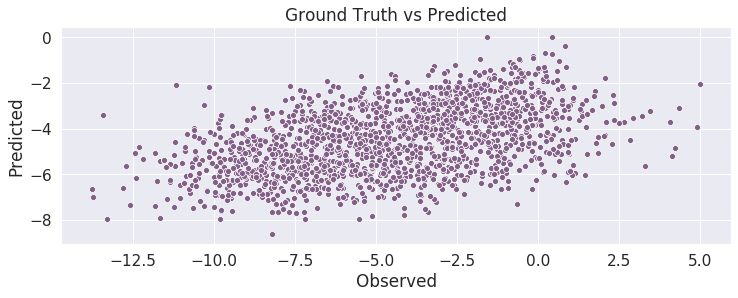

In [629]:
# first random grid
# plot best model observed vs. predictions using positive target
plot_predictions(X_log_pos, y_log_pos, best_model_log_pos)

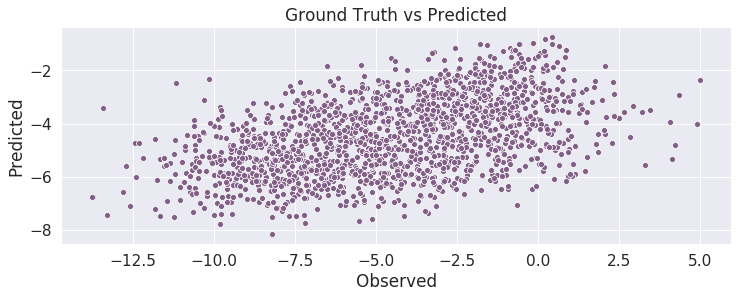

In [725]:
# second random grid
# plot best model observed vs. predictions using positive target
plot_predictions(X_log_pos, y_log_pos, best_model_log_pos)

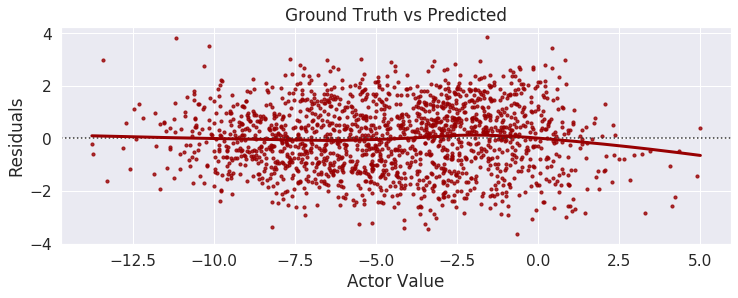

In [630]:
# first random grid
# plot residuals for best model using positive target
plot_residuals(X_log_pos, y_log_pos, best_model_log_pos)

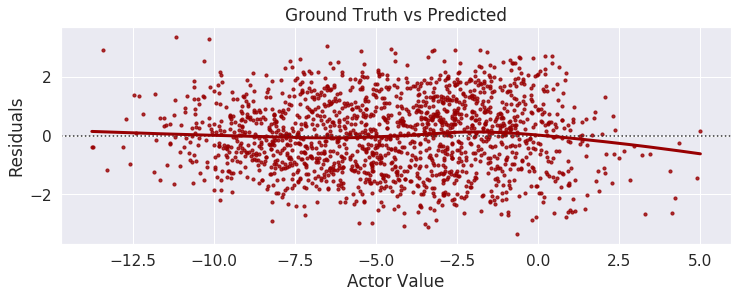

In [726]:
# second random grid
# plot residuals for best model using positive target
plot_residuals(X_log_pos, y_log_pos, best_model_log_pos)

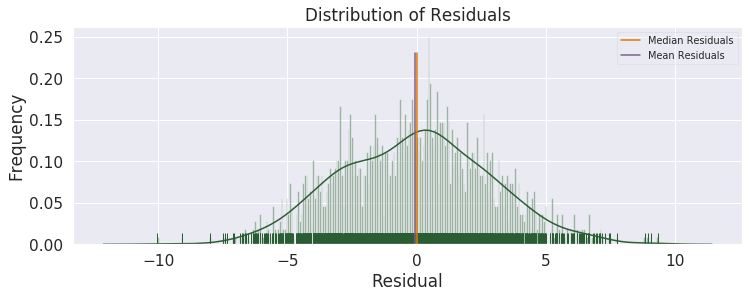

In [631]:
# first random grid
# plot residuals for best model using positive target
plot_residual_distribution(X_log_pos, y_log_pos, best_model_log_pos)

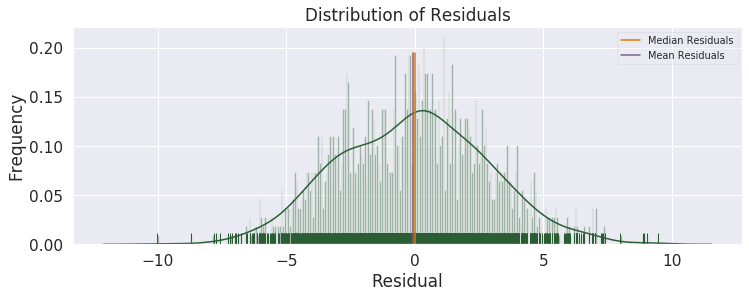

In [727]:
# second random grid
# plot residuals for best model using positive target
plot_residual_distribution(X_log_pos, y_log_pos, best_model_log_pos)